In [1]:
import numpy as np
import torch 
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_batch_size = 64    #每批处理的训练集数据
test_batch_size = 64     #每批处理的测试集数据
learning_rate = 0.001     #学习率
num_epoches = 20         #训练数据集的轮次
lr = 0.001                #学习率
momentum = 0.99          #动量

In [3]:
#加载数据集
dataset = torch.load('dataset_new.pt')
np.random.shuffle(dataset)

食用油桶


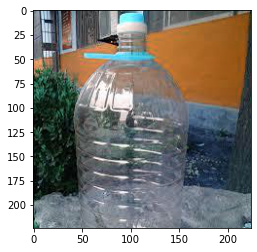

In [4]:
#可视化
labelIndex = {0: '传单', 1: '充电宝', 2: '包', 3: '塑料玩具', 4: '塑料碗盆', 5: '塑料衣架', 6: '快递纸袋', 7: '报纸', 8: '插头电线', 9: '旧书', 10: '旧衣服', 11: '易拉罐', 12: '杂志', 13: '枕头', 14: '毛绒玩具', 15: '泡沫塑料', 16: '洗发水瓶', 17: '牛奶盒等利乐包装', 18: '玻璃', 19: '玻璃瓶罐', 20: '皮鞋', 21: '砧板', 22: '纸板箱', 23: '调料瓶', 24: '酒瓶', 25: '金属食品罐', 26: '锅', 27: '食用油桶', 28: '饮料瓶', 29: '干电池', 30: '废弃水银温度计', 31: '废旧灯管灯泡', 32: '杀虫剂容器', 33: '电池', 34: '软膏', 35: '过期药物', 36: '除草剂容器', 37: '剩菜剩饭', 38: '大骨头', 39: '果壳瓜皮', 40: '残枝落叶', 41: '水果果皮', 42: '水果果肉', 43: '茶叶渣', 44: '菜梗菜叶', 45: '落叶', 46: '蛋壳', 47: '西餐糕点', 48: '鱼骨', 49: '一次性餐具', 50: '化妆品瓶', 51: '卫生纸', 52: '尿片', 53: '污损塑料', 54: '烟蒂', 55: '牙签', 56: '破碎花盆及碟碗', 57: '竹筷', 58: '纸杯', 59: '贝壳'}
i = np.random.randint(len(dataset))
plt.imshow(dataset[i][0])
print(labelIndex[dataset[i][1]])

In [5]:
len(dataset)

38774

In [6]:
#图片预处理
transform = transforms.Compose([
    transforms.ToTensor(),                                               # 归一化
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),  # 标准化
])
for i in range(len(dataset)):
    dataset[i][0] = transform(dataset[i][0].numpy())
    if i%5000 == 0:
        time.sleep(0.5)
        print(i)

0
5000
10000
15000
20000
25000
30000
35000


In [7]:
#样本数
m = len(dataset) // 320
m = m*320
m 

38720

In [8]:
# 训练集 测试集
train_dataset = dataset[:int(m*0.8)]        # 80% 训练集
test_dataset = dataset[int(m*0.8):int(m)]   # 20% 测试集
# 加载数据
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)

In [9]:
#清空缓存
dataset=[]
train_dataset=[]
test_dataset=[]

In [10]:
net = models.resnet18(pretrained=False)
# 修改全连接层的输出
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 60)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum,weight_decay=0.001) 

In [13]:
def get_4class(a):
    if a >= 0 and a < 29:
        return 0
    elif a < 37:
        return 1
    elif a < 49:
        return 2
    elif a < 60:
        return 3
    else:
        return -1 #错误

In [14]:
cost = []           # 损失函数
train_acc  = []     # 60分类训练集准确率
test_acc  = []      # 60分类测试集准确率
train_acc_4 = []    # 4分类训练集准确率
test_acc_4 = []     # 4分类测试集准确率

In [15]:
for epoch in range(num_epoches):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # 输入样本和标签
        inputs, labels = data[0],data[1]
        inputs = inputs.view(train_batch_size, -1, 224, 224)  #转化为 4 维，第 2 维自动判断
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs.float())  # 这里的输入是 4 维的
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # 记录误差
        running_loss += loss.item()
        if (i+1) % 100 == 0:
            print("[epoch: %d, mini-batch: %5d] loss: %.3f" % 
                  (epoch + 1, i + 1, running_loss / 100))  # 每训练 100 批样本打印一次平均误差
            cost.append(running_loss / 100)
            running_loss = 0.0 


    correct = 0     # 预测正确的个数
    correct_4 = 0   # 4分类预测正确的个数
    total = 0       # 总样本个数
    net.eval()
    with torch.no_grad(): # 关闭梯度
        for data in train_loader:
            inputs, labels = data
            inputs = inputs.view(train_batch_size,-1,224,224)
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = net(inputs.float())
            _, pred = torch.max(outputs.data, 1)      # 选取最大概率的那个标签为预测结果
            total += labels.size(0)                   # 总样本个数加 1
            correct += (pred == labels).sum().item()  # 如果预测正确，correct加 1
            for i in range(len(labels)):
                if get_4class(pred[i]) == get_4class(labels[i]):
                    correct_4 += 1
    train_acc.append(correct / total)
    print("训练集上的60分类准确率: %.3f" % (correct / total))
    train_acc_4.append(correct_4 / total)
    print("训练集上的4分类准确率: %.3f" % (correct_4 / total))


    correct = 0     
    correct_4 = 0   
    total = 0       
    net.eval()
    with torch.no_grad(): # 关闭梯度
        for data in test_loader:
            inputs, labels = data
            inputs = inputs.view(test_batch_size, -1, 224, 224)
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = net(inputs.float())
            _, pred = torch.max(outputs.data, 1)      # 选取最大概率的那个标签为预测结果
            total += labels.size(0)                   # 总样本个数加 1
            correct += (pred == labels).sum().item()  # 如果预测正确，correct加 1
            for i in range(len(labels)):
                if get_4class(pred[i]) == get_4class(labels[i]):
                    correct_4 += 1
    test_acc.append(correct / total)
    print("测试集上的60分类准确率: %.3f" % (correct / total))
    test_acc_4.append(correct_4 / total)
    print("测试集上的4分类准确率: %.3f" % (correct_4 / total))

    path = f'./models/resnet18_{epoch}.pkl'
    torch.save(net.state_dict(), path)

[epoch: 1, mini-batch:   100] loss: 3.830
[epoch: 1, mini-batch:   200] loss: 3.496
[epoch: 1, mini-batch:   300] loss: 3.326
[epoch: 1, mini-batch:   400] loss: 3.118
训练集上的60分类准确率: 0.261
训练集上的4分类准确率: 0.644
测试集上的60分类准确率: 0.253
测试集上的4分类准确率: 0.647
[epoch: 2, mini-batch:   100] loss: 2.833
[epoch: 2, mini-batch:   200] loss: 2.783
[epoch: 2, mini-batch:   300] loss: 2.773
[epoch: 2, mini-batch:   400] loss: 2.637
训练集上的60分类准确率: 0.337
训练集上的4分类准确率: 0.691
测试集上的60分类准确率: 0.321
测试集上的4分类准确率: 0.681
[epoch: 3, mini-batch:   100] loss: 2.527
[epoch: 3, mini-batch:   200] loss: 2.430
[epoch: 3, mini-batch:   300] loss: 2.364
[epoch: 3, mini-batch:   400] loss: 2.347
训练集上的60分类准确率: 0.406
训练集上的4分类准确率: 0.727
测试集上的60分类准确率: 0.386
测试集上的4分类准确率: 0.721
[epoch: 4, mini-batch:   100] loss: 2.187
[epoch: 4, mini-batch:   200] loss: 2.147
[epoch: 4, mini-batch:   300] loss: 2.135
[epoch: 4, mini-batch:   400] loss: 2.058
训练集上的60分类准确率: 0.466
训练集上的4分类准确率: 0.764
测试集上的60分类准确率: 0.434
测试集上的4分类准确率: 0.741
[epoch: 5, mini-

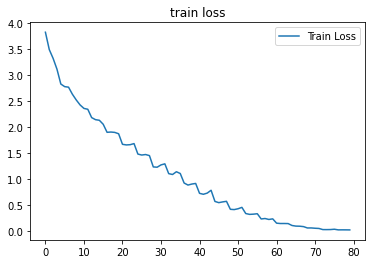

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('train loss')
plt.plot(np.arange(len(cost)), cost)
plt.legend(['Train Loss'], loc='upper right')

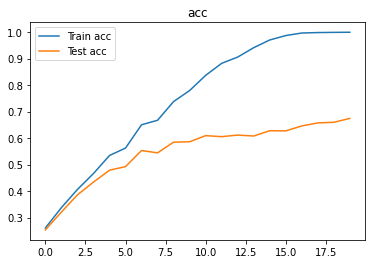

In [17]:
#60分类准确率
plt.title('acc')
plt.plot(np.arange(len(train_acc)), train_acc)
plt.plot(np.arange(len(test_acc)), test_acc)
plt.legend(['Train acc','Test acc'])

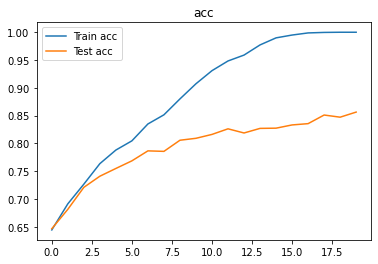

In [18]:
#4分类准确率
plt.title('acc')
plt.plot(np.arange(len(train_acc_4)), train_acc_4)
plt.plot(np.arange(len(test_acc_4)), test_acc_4)
plt.legend(['Train acc','Test acc'])

In [38]:
# correct = 0  # 预测正确的个数
# total = 0    # 总样本个数
# net.eval()
# with torch.no_grad(): # 关闭梯度
#     for data in train_loader:
#         inputs, labels = data
#         inputs = inputs.view(test_batch_size, -1, 224, 224)
#         inputs, labels = inputs.to(device), labels.to(device)
        
#         outputs = net(inputs.float())
#         _, pred = torch.max(outputs.data, 1)      # 选取最大概率的那个标签为预测结果
#         total += labels.size(0)                   # 总样本个数加 1

#         for i in range(len(labels)):
#             if get_4class(pred[i]) == get_4class(labels[i]):
#                 correct += 1
#         #correct += (pred == labels).sum().item()  # 如果预测正确，correct加 1
# print("训练集上四分类的准确率：%.3f" % (correct / total))

训练集上四分类的准确率：0.996


In [31]:
# correct = 0  # 预测正确的个数
# total = 0    # 总样本个数
# net.eval()
# with torch.no_grad(): # 关闭梯度
#     for data in test_loader:
#         inputs, labels = data
#         inputs = inputs.view(test_batch_size, -1, 224, 224)
#         inputs, labels = inputs.to(device), labels.to(device)
        
#         outputs = net(inputs.float())
#         _, pred = torch.max(outputs.data, 1)      # 选取最大概率的那个标签为预测结果
#         total += labels.size(0)                   # 总样本个数加 1

#         for i in range(len(labels)):
#             if get_4class(pred[i]) == get_4class(labels[i]):
#                 correct += 1
#         #correct += (pred == labels).sum().item()  # 如果预测正确，correct加 1
# print("测试集上四分类的准确率：%.3f" % (correct / total))

测试集上四分类的准确率：0.798


In [19]:
print(f"训练集上的4分类最高准确率:{max(train_acc_4)} index:{train_acc_4.index(max(train_acc_4))}")
print(f"测试集上的4分类最高准确率:{max(test_acc_4)} index:{test_acc_4.index(max(test_acc_4))}")

训练集上的4分类最高准确率:0.9998385847107438 index:18
测试集上的4分类最高准确率:0.856275826446281 index:19


In [20]:
print(train_acc)
print(test_acc)
print(train_acc_4)
print(test_acc_4)

[0.2606856921487603, 0.3374870867768595, 0.40595945247933884, 0.46603822314049587, 0.5340263429752066, 0.5621126033057852, 0.6500193698347108, 0.6670002582644629, 0.737603305785124, 0.7790870351239669, 0.8363248966942148, 0.8818117252066116, 0.9054106404958677, 0.9408574380165289, 0.9699121900826446, 0.986667097107438, 0.9962551652892562, 0.9979661673553719, 0.9987086776859504, 0.999192923553719]
[0.25322830578512395, 0.32076446280991733, 0.3855888429752066, 0.43362603305785125, 0.47856404958677684, 0.4921229338842975, 0.5528150826446281, 0.5440340909090909, 0.5844524793388429, 0.5858729338842975, 0.6089876033057852, 0.6051136363636364, 0.6111828512396694, 0.6075671487603306, 0.6275826446280992, 0.6269369834710744, 0.6455320247933884, 0.6570247933884298, 0.659349173553719, 0.6739411157024794]
[0.644402117768595, 0.691277117768595, 0.7266593491735537, 0.7635266012396694, 0.7879971590909091, 0.804558367768595, 0.8349044421487604, 0.8513688016528925, 0.8799393078512396, 0.9072184917355371

In [21]:
torch.save(net.state_dict(), 'resnet18.pkl')